## LSTM Example

We want to train an univariate, one feature LSTM

**0) Loading Libraries and Subroutines**

Standard libraries for plotting and numerical operations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Loading LSTM related keras libraries:

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import numpy as np
from keras import optimizers
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

Calling a subroutine that puts data set in the correct shape for LSTM (see later)

In [3]:
def prepare_data(data, n_past, n_future):
    x, y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        x.append(data[i - n_past:i])
        y.append(data[i:i + n_future])
    return np.array(x), np.array(y)

<br>

**1) Generating a Simple Dataset**

In [4]:
t_start = -50
t_end   = 10
incr    = 0.25

t       = np.arange(t_start, t_end, incr)
t       = t.reshape(len(t), 1)
Y_t     = np.sin(t) + 0.1*np.random.randn(len(t), 1) + np.exp((t + 20)*0.05)

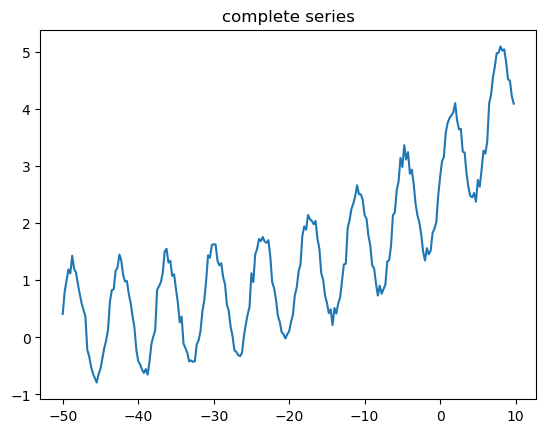

In [5]:
plt.plot(t, Y_t)
plt.title('complete series')
plt.show()

**2) Preprocessing the Data**

2a) Scaling:

In [6]:
scaler  = MinMaxScaler(feature_range = (0, 1))
Y_tnorm = scaler.fit_transform(Y_t)

2b) Reshaping the Data

The dataset has only one feature. We want to predict *dt_futu* data points into the future and train the LSTM with the previous *dt_past* time steps to predict the next. For that purpose, we need to reshape the data in such a way that *dt_futu* is interpreted as features. Therefore, we run the following subroutine:<br>
<br>

In [7]:
dt_past    = 20
dt_futu    = 8
n_features = 1

[X, Y] = prepare_data(Y_tnorm, dt_past, dt_futu)

<br>

Let us check the shapes:

In [8]:
print(Y_tnorm.shape)
print(X.shape)
print(Y.shape)

(240, 1)
(213, 20, 1)
(213, 8, 1)


In order to train the LSTM with $dt_{futu}$ and $dt_{past}$, we need the first $dt_{past}$ steps in order to train for the next prediction. The length of the period we want to predict is $dt_{futu}$. The last step in the training will be the point, when we predict the last sequence $dt_{futu}$ with the previous steps $dt_{past}$. Thus, the training data set has the length $len\left(Y_{tnorm}\right) - dt_{past} - dt_{futu} + 1$. Each time point in the past we need for the prediction will have its own influence on the future and therefore are regarded as feature. Thus, $X$ has to have the shape $\left[len\left(Y_{tnorm}\right) - dt_{past} - dt_{futu} + 1\right] \times dt_{past}$.<br>   
Because of that interpretation, each feature is shifted by one time point:

In [9]:
print(X[:dt_past, :dt_past, 0])

[[0.20430224 0.27022895 0.30284581 0.33650083 0.32467718 0.37713609
  0.33816306 0.32758972 0.29333423 0.26328484 0.23585075 0.21545527
  0.19656775 0.09713384 0.07798692 0.04643554 0.02671805 0.01276146
  0.         0.02538024]
 [0.27022895 0.30284581 0.33650083 0.32467718 0.37713609 0.33816306
  0.32758972 0.29333423 0.26328484 0.23585075 0.21545527 0.19656775
  0.09713384 0.07798692 0.04643554 0.02671805 0.01276146 0.
  0.02538024 0.04078677]
 [0.30284581 0.33650083 0.32467718 0.37713609 0.33816306 0.32758972
  0.29333423 0.26328484 0.23585075 0.21545527 0.19656775 0.09713384
  0.07798692 0.04643554 0.02671805 0.01276146 0.         0.02538024
  0.04078677 0.07268213]
 [0.33650083 0.32467718 0.37713609 0.33816306 0.32758972 0.29333423
  0.26328484 0.23585075 0.21545527 0.19656775 0.09713384 0.07798692
  0.04643554 0.02671805 0.01276146 0.         0.02538024 0.04078677
  0.07268213 0.1030173 ]
 [0.32467718 0.37713609 0.33816306 0.32758972 0.29333423 0.26328484
  0.23585075 0.21545527 

<br>

Following the same logic, in order to train the LSTM to predict the future $dt_{futu}$ ahead, $Y$ needs to have the same structure: 

In [10]:
print(Y[:dt_futu, :dt_futu, 0])

[[0.04078677 0.07268213 0.1030173  0.1250332  0.1571585  0.24082531
  0.27471749 0.2777322 ]
 [0.07268213 0.1030173  0.1250332  0.1571585  0.24082531 0.27471749
  0.2777322  0.33231079]
 [0.1030173  0.1250332  0.1571585  0.24082531 0.27471749 0.2777322
  0.33231079 0.34132439]
 [0.1250332  0.1571585  0.24082531 0.27471749 0.2777322  0.33231079
  0.34132439 0.38078988]
 [0.1571585  0.24082531 0.27471749 0.2777322  0.33231079 0.34132439
  0.38078988 0.36349241]
 [0.24082531 0.27471749 0.2777322  0.33231079 0.34132439 0.38078988
  0.36349241 0.31952106]
 [0.27471749 0.2777322  0.33231079 0.34132439 0.38078988 0.36349241
  0.31952106 0.30067035]
 [0.2777322  0.33231079 0.34132439 0.38078988 0.36349241 0.31952106
  0.30067035 0.30208964]]


<br>

2c) Splitting data into Training and Test dataset

In [11]:
cut            = int(np.round(0.7*Y_tnorm.shape[0]))

TrainX, TrainY = X[:cut], Y[:cut]
TestX,   TestY = X[cut:], Y[cut:]

Just to make sure, that the shape is *len(X) x dt_past x n_features*

In [12]:
print(TrainX.shape, TestX.shape)

(168, 20, 1) (45, 20, 1)


<br>

**3) Creating the Model**

Creating a LSTM in Python follows the same syntax as for CNNs. We want to predict data points in the future, based on previous data points. Therefore, we need to solve a **regression** problem:<br>

In [ ]:
n_neurons  = 400
batch_size = 128

model = Sequential()
model.add(LSTM(n_neurons, input_shape = (dt_past, n_features), activation = 'tanh'))
model.add(Dense(dt_futu))

opt = optimizers.Adam()
model.compile(loss = 'mean_squared_error', optimizer = opt)

# Build the model by calling it on a dummy batch
dummy_input = np.zeros((1, dt_past, n_features))
_ = model(dummy_input)

model.summary()

/Users/zhengxiaoyang/miniconda/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 400)            │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         3,208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,808 (18.78 KB)

 Trainable params: 4,808 (18.78 KB)

 Non-trainable params: 0 (0.00 B)

<br>

**4) Running the Fit**

In [15]:
n_epochs = 200
out = model.fit(TrainX, TrainY, epochs = n_epochs, batch_size = batch_size, validation_split = 0.2, verbose = 'auto', shuffle = True)

RuntimeError: Unable to automatically build the model. Please build it yourself before calling fit/evaluate/predict. A model is 'built' when its variables have been created and its `self.built` attribute is True. Usually, calling the model on a batch of data is the right way to build it.
Exception encountered:
'Exception encountered when calling LSTM.call().

[1m'LSTMCell' object has no attribute 'recurrent_kernel'[0m

Arguments received by LSTM.call():
  • sequences=torch.Tensor(shape=torch.Size([128, 20, 1]), dtype=float32)
  • initial_state=None
  • mask=None
  • training=False'

In [ ]:
#plotting #############################################################
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.savefig('training loss.pdf')
plt.show()
#######################################################################

<br>

**5) Evaluating the Fit**

In [ ]:
PredY = model.predict(TestX)
back  = PredY.shape[0]

In [ ]:
print(back)# must equal TestX.shape[0]

In [ ]:
plt.plot(t, Y_tnorm, linewidth = 5)
plt.plot(t[-back:], PredY[:, dt_futu-1])
plt.legend(['actual data', 'prediction'])
plt.fill_between([t[-back,0], t[-1,0]], 0, 1, color = 'k', alpha = 0.1)
plt.plot([t[-back,0], t[-back,0]], [0, 1], 'k-', linewidth = 3)
plt.show()

In [ ]:
print(PredY.shape)

In [ ]:
print(TestX.shape)

In [ ]:
PredY[:,:5]

Since the predicted values in each column of PredY refer to different sequences in the future, each shifted by one time point, we can also plot with respect to another reference point (note: for plotting the t axes needs to be shifted by the same time step!):

In [ ]:
#dt_back = 6 #0....dt_futu

#prediction from different reference points
for dt_back in range(dt_futu):
    plt.plot(t, Y_tnorm, linewidth = 5)
    plt.plot(t[-back:] - incr*dt_back, PredY[:, dt_futu-1-dt_back])
    plt.legend(['actual data', 'prediction'])
    plt.fill_between([t[-back,0], t[-1,0]], 0, 1, color = 'k', alpha = 0.1)
    plt.plot([t[-back,0], t[-back,0]], [0, 1], 'k-', linewidth = 3)
    plt.title('reference point dt_futu = ' + str(dt_futu-1-dt_back))
    plt.show()